# Normalization

#### 1. Importing the libraries

In [1]:
import os
import numpy as np
from datetime import datetime, date, timedelta
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from datetime import datetime
import matplotlib.pyplot as plt

dateT = '03_17_23'

#### 2. Loading the data into training and validation set

In [2]:
train = keras.utils.image_dataset_from_directory(
    directory = './dataset',
    validation_split=0.1,
    subset='training',
    seed=123,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (128, 128),
)

Found 17125 files belonging to 20 classes.
Using 15413 files for training.


In [3]:
val = keras.utils.image_dataset_from_directory(
    directory = './dataset',
    validation_split=0.2,
    subset='validation',
    seed=123,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (128, 128),
)

Found 17125 files belonging to 20 classes.
Using 3425 files for validation.


#### 3. Normalizing the image dataset

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_norm = train.map(lambda x, y: (normalization_layer(x), y))
val_norm = val.map(lambda x, y: (normalization_layer(x), y))

#### 4. Initializing the model architechture

In [48]:
# Model configuration

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)
relu = 'relu'
tanh = 'tanh'
sigmoid = 'sigmoid'
thresh_relu = tf.keras.layers.ThresholdedReLU(0.1)

In [49]:
model = tf.keras.Sequential([
    Conv2D(4, kernel_size=(5,5), padding='valid', activation=leaky_relu, input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2), padding='valid'),
    Dropout(rate=0.2),

    Conv2D(2, kernel_size=(5,5), padding='valid', activation=leaky_relu),
    MaxPooling2D(pool_size=(2,2), padding='valid'),
    Dropout(rate=0.3),

    Flatten(),
    Dense(64, activation=leaky_relu),
    Dropout(rate=0.4),
    Dense(20, activation=sigmoid)
])

In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 124, 124, 4)       304       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 4)        0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 62, 62, 4)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 58, 58, 2)         202       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 29, 29, 2)        0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 29, 29, 2)        

In [ ]:
# Run to clear the learned weights

tf.keras.backend.clear_session()

In [ ]:
# Run to load previous weights

yesterday = '01_23_23'

path='model_checkpoints/' + yesterday + '/model.pkl'

model.load_weights(path)

In [54]:
# class myCallback(tf.keras.callbacks.Callback):
# 	def on_epoch_end(self, epoch, logs={}):
# 		if(logs.get('accuracy') > 0.80):
# 			print(logs)
# 			print("\nReached the required accuracy, so stopping training!!")
# 			self.model.stop_training = True

# callback = myCallback()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.02,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.05,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adam',
)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_norm, epochs=50, validation_data=val_norm, callbacks=[callback])

Epoch 1/50
482/482 [==============================] - 11s 22ms/step - loss: 19.8507 - accuracy: 0.3280 - val_loss: 2.2887 - val_accuracy: 0.4053
Epoch 2/50
482/482 [==============================] - 11s 23ms/step - loss: 2.3590 - accuracy: 0.3974 - val_loss: 2.2444 - val_accuracy: 0.4055
Epoch 3/50
482/482 [==============================] - 11s 22ms/step - loss: 2.2846 - accuracy: 0.3989 - val_loss: 2.2365 - val_accuracy: 0.3965
Epoch 4/50
482/482 [==============================] - 12s 24ms/step - loss: 2.2298 - accuracy: 0.4038 - val_loss: 2.1281 - val_accuracy: 0.4184
Epoch 5/50
482/482 [==============================] - 12s 24ms/step - loss: 2.2183 - accuracy: 0.4015 - val_loss: 2.1116 - val_accuracy: 0.4114
Epoch 6/50
482/482 [==============================] - 13s 26ms/step - loss: 2.2157 - accuracy: 0.4008 - val_loss: 2.0694 - val_accuracy: 0.4219
Epoch 7/50
482/482 [==============================] - 12s 25ms/step - loss: 2.2200 - accuracy: 0.4002 - val_loss: 2.0851 - val_accuracy

In [29]:
path='model_checkpoints/'+dateT+'/model3.pkl'
model.save_weights(path)

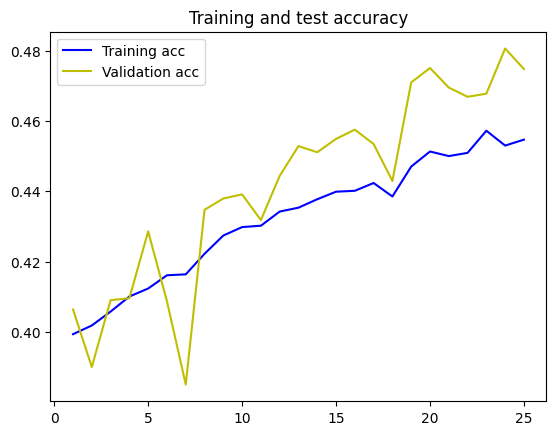

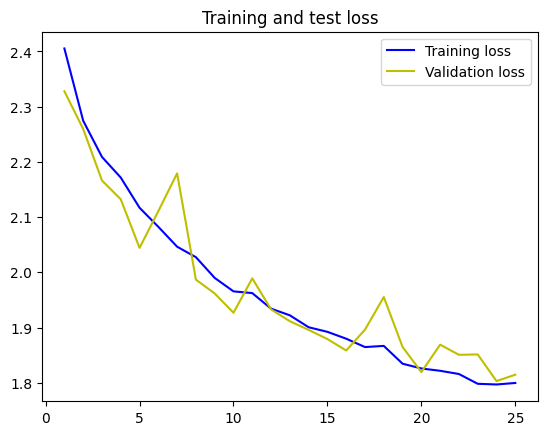

In [30]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'y', label='Validation acc')
plt.title('Training and test accuracy')
plt.legend()
plt.savefig('model_checkpoints/'+dateT+'/accuracy3.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and test loss')
plt.legend()
plt.savefig('model_checkpoints/'+dateT+'/loss3.png', bbox_inches='tight')
plt.show()

#### 4. Plot the model statistics till latest training

In [ ]:
t_acc = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_train_acc.npy')
t_loss = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_train_loss.npy')
v_acc = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_val_acc.npy')
v_loss = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_val_loss.npy')

accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

t_acc = np.append(t_acc, accuracy)
t_loss = np.append(t_loss, loss)
v_acc = np.append(v_acc, val_accuracy)
v_loss = np.append(v_loss, val_loss)

np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_train_acc.npy', t_acc)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_train_loss.npy', t_loss)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_val_acc.npy', v_acc)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_val_loss.npy', v_loss)

epochs = range(1, len(t_acc) + 1)

plt.plot(epochs, t_acc, 'b', label='Training acc')
plt.plot(epochs, v_acc, 'y', label='Validation acc')
plt.title('Training and test accuracy')
plt.legend()
plt.savefig('model_checkpoints/'+dateT+'/modelStatsTillDate_accuracy.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, t_loss, 'b', label='Training loss')
plt.plot(epochs, v_loss, 'y', label='Validation loss')
plt.title('Training and test loss')
plt.legend()
plt.savefig('model_checkpoints/'+dateT+'/modelStatsTillDate_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
temp = np.array([history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']])
np.save('model_checkpoints/'+dateT+'/metrics5.npy', temp)

In [ ]:
t_acc = np.array([])
t_loss = np.array([])
v_acc = np.array([])
v_loss = np.array([])

In [ ]:
t_acc = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_train_acc.npy')
t_loss = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_train_loss.npy')
v_acc = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_val_acc.npy')
v_loss = np.load('model_checkpoints/'+yesterday+'/modelStatsTillDate_val_loss.npy')

metrics = np.load('model_checkpoints/'+dateT+'/metrics5.npy')
acc = metrics[0]
loss = metrics[1]
val_acc = metrics[2]
val_loss = metrics[3]

t_acc = np.append(t_acc, acc)
t_loss = np.append(t_loss, loss)
v_acc = np.append(v_acc, val_acc)
v_loss = np.append(v_loss, val_loss)

In [ ]:
np.shape(t_acc)

In [ ]:
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_train_acc.npy', t_acc)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_train_loss.npy', t_loss)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_val_acc.npy', v_acc)
np.save('model_checkpoints/'+dateT+'/modelStatsTillDate_val_loss.npy', v_loss)